# Name: Peng Zhang 
# ZId: z5272579

# Introduction
In the modern world, driving is one of the most essential modes of transportation. In order to prevent drivers from disobeying traffic signs, avoid dangers, and promote safer driving, this computer vision project focuses on developing models that employ forward-sensing cameras to recognise traffic signals. 

# Data Sources
Source: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign <br /> Description: For this project, we will use this GTSRB - German Traffic Sign Recognition Benchmark dataset. This is because it is large, lifelike database and contains 43 classes of images and more than 50,000 images. In addition, the images are in RGB with 30x30 pixels and the test folder contains 12.6k images. What's more, the size of images is between 30 x 25 and 266 x 232. 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Dataset Detail

## Exploratory Analysis of Data 
### number of classes: 43
The number of training images of all the classes are shown in the figure. The method of resampling is not necessary. This is because that according to the figure below, the difference between the most and the least number of a class is only 2000, which is not a large proportion compared to the total training set.

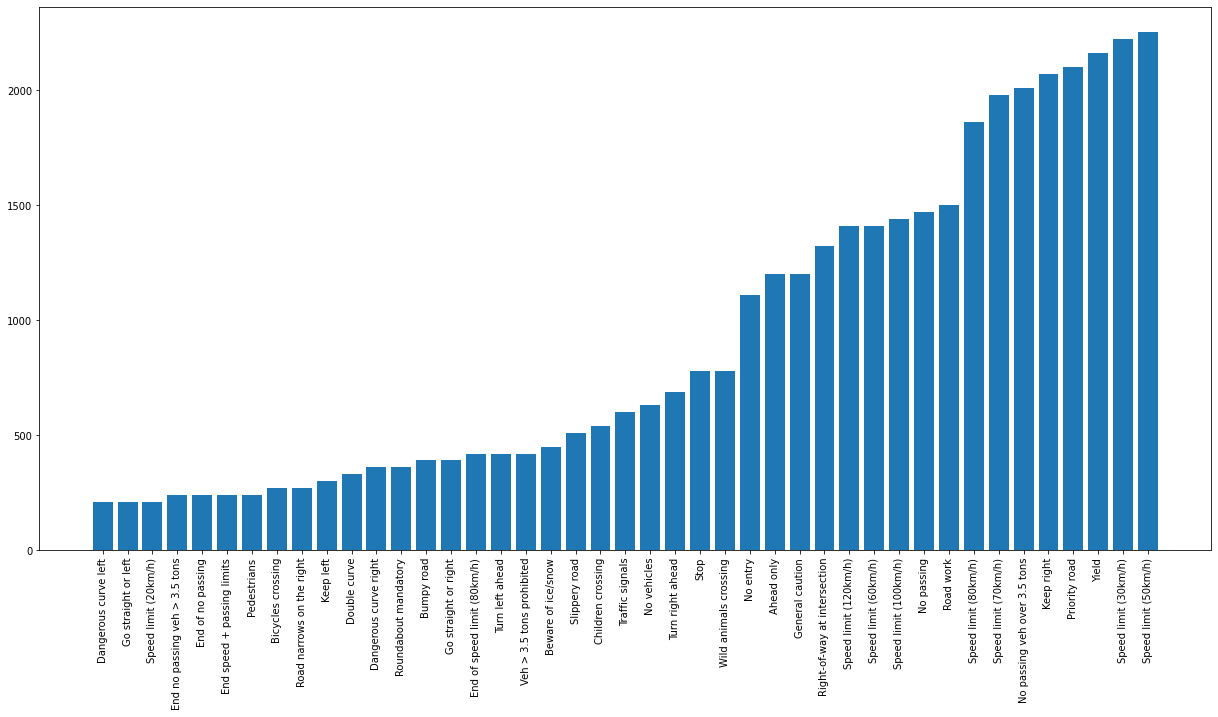

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

trainFolder = '/kaggle/input/gtsrb-german-traffic-sign/Train'
trainFolders = os.listdir(trainFolder)

trainNumber = []
classNum = []

for folder in trainFolders:
    trainFiles = os.listdir(trainFolder + '/' + folder)
    trainNumber.append(len(trainFiles))
    classNum.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipList = zip(trainNumber, classNum)
sortedPairs = sorted(zipList)
tuples = zip(*sortedPairs)
trainNumber, classNum = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(classNum, trainNumber)
plt.xticks(classNum, rotation='vertical')
plt.show()

### Pre-processing Method: 30x30, Rotation, Resize, CenterCrop, Normalize.
The input images are resized to 30 x 30 and center cropped. In addition, the rotation method is used to input images. Image matrix values are normalized to ensure optimal comparison between data acquisition methods and texture instances, making the model less sensitive to the proportions of features and able to avoid gradient explosion/disappearance.

### Challenging Aspect
There is one challenging aspect which is the different size of the images. When the image size is set to be 266 x 232, the training will be broken. This is because the longer time processing for large images and the RAM memoory limitation. Thus to solve this challenge, resizing the iamge to 30 x 30 is necessary for increasing the training speed and maintaining the test accuracy.

In [ ]:
basePath = '../input/gtsrb-german-traffic-sign/'
data = pd.read_csv('../input/gtsrb-german-traffic-sign/Train.csv', usecols=['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path'])
trainData = data.iloc[:, :-2]
trainLabel = data.iloc[:, -2]
trainset = []
for imgPath in data['Path']:
    try:
        image = Image.open(basePath + imgPath).convert('RGB')
        tf = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.Resize(30),
            transforms.CenterCrop(30),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])  # from imagenet
        ])
        trainset.append(tf(image).numpy())
    except:
        print("Error in " + imgPath)



In [ ]:
XTrain, XValid, YTrain, YValid = train_test_split(trainset, trainLabel.values, test_size=0.2, shuffle=True)

# Models: AlexNet
The following code simulates AlexNet's eight layers. The first five are convolutional layers, some of them follow by max-pooling layers, and the last three are fully connected layers. It uses the non-saturating Rectified Linear Unit activation function.

AlexNet applies Max-pooling after the first, second, and fifth convolutional layers. The kernels of the second, fourth, and fifth convolutional layers are connected only to those kernel maps in the previous layer, which reside on the same GPU. The kernels of the third convolutional layer are connected to all kernel maps in the second layer. The neurons in the fully connected layers are connected to all neurons in the previous layer.  Dropout is applied in the first two fully connected layers. And the last layer produces 43 neurons. Reference source: https://analyticsindiamag.com/hands-on-guide-to-implementing-alexnet-with-keras-for-multi-class-image-classification/

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Normalization
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import *
import warnings

model = Sequential()

#1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(30,30,3), kernel_size=(11,11), strides=(4,4), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(30,30,3,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.5))

#2nd Fully Connected Layer
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
#Add Dropout
model.add(Dropout(0.5))

#3rd Fully Connected Layer
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation('relu'))
#Add Dropout
model.add(Dropout(0.4))

#Output Layer
model.add(Dense(43))
model.add(BatchNormalization())
model.add(Activation('softmax'))

#Model Summary
model.build()
model.summary()

2022-11-19 06:36:50.980848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 06:36:50.981955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 06:36:50.982967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 06:36:50.983768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 06:36:50.984524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 96)          384       
_________________________________________________________________
activation (Activation)      (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 256)         0

## AlexNet Optimizer
The "Adam" optimizer, which combines momentum and root mean square propagation forces, is used to provide optimized gradient descent. "Adam" was chosen because it has a faster computation time and fewer parameters to tune. The learning rate is set to "1e-3", so that it is neither too small to extend the training time, nor too large to cause the loss function divergence behavior that is not desired.

## Deep CNN Model Training Adjustment
"loss" is set as "sparse_categorical_crossentropy", for the input labels are integers rather than in one hot representation. "Accuracy" can be a good metrics for this dataset, since the dataset is not imbalanced.

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
XTrain = np.array(XTrain).reshape(len(XTrain), 30, 30, 3)
XValid = np.array(XValid).reshape(len(XValid), 30, 30, 3)
YTrain = np.array(YTrain).astype(np.float)
YValid = np.array(YValid).astype(np.float)
print(XTrain.shape)


(31367, 30, 30, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


## Training

In [ ]:
history = model.fit(XTrain ,YTrain,  batch_size = 128, 
         epochs=70, validation_data = (XValid, YValid),
          callbacks=[callback, reduce_lr], shuffle = True)

2022-11-19 06:37:02.676691: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-11-19 06:37:05.909681: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


246/246 [==============================] - 20s 26ms/step - loss: 3.1142 - accuracy: 0.1755 - val_loss: 3.9784 - val_accuracy: 0.1503
Epoch 2/70
246/246 [==============================] - 5s 21ms/step - loss: 1.9921 - accuracy: 0.4322 - val_loss: 2.7498 - val_accuracy: 0.2771
Epoch 3/70
246/246 [==============================] - 5s 22ms/step - loss: 1.5747 - accuracy: 0.5497 - val_loss: 2.7120 - val_accuracy: 0.3230
Epoch 4/70
246/246 [==============================] - 5s 22ms/step - loss: 1.2827 - accuracy: 0.6287 - val_loss: 1.4355 - val_accuracy: 0.5800
Epoch 5/70
246/246 [==============================] - 5s 22ms/step - loss: 1.0855 - accuracy: 0.6847 - val_loss: 1.7496 - val_accuracy: 0.5195
Epoch 6/70
246/246 [==============================] - 5s 22ms/step - loss: 0.9225 - accuracy: 0.7286 - val_loss: 1.5192 - val_accuracy: 0.5560
Epoch 7/70
246/246 [==============================] - 6s 23ms/step - loss: 0.8123 - accuracy: 0.7618 - val_loss: 1.5746 - val_accuracy: 0.5385
Epoch 8/7

# Accuracy Visualization
The changes in training accuracy and validation accuracy as the number of epochs increase are shown in the figure below

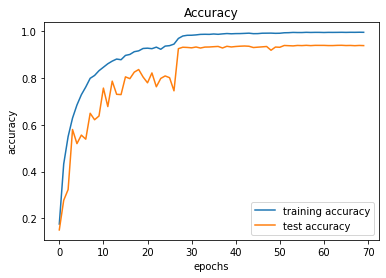

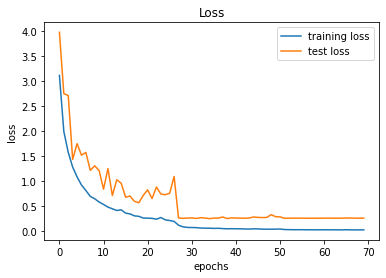

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# Results

In [ ]:
testData = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
testLabel = testData["ClassId"].values
testset = []

for imgPath in testData['Path']:
    try:
        image = Image.open(basePath + imgPath).convert('RGB')
        tf = transforms.Compose([
            transforms.Resize(30),
            transforms.CenterCrop(30),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])  # from imagenet
        ])
        testset.append(tf(image).numpy())
    except:
        print("Error in " + imgPath)


In [ ]:
# print(np.array(testset).shape)
XTest = np.array(testset).reshape(len(testset), 30, 30, 3)
YTest = np.array(testLabel).astype(np.float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
model.evaluate(XTest, YTest)

395/395 [==============================] - 2s 5ms/step - loss: 1.0425 - accuracy: 0.7918


[1.0424842834472656, 0.7918447852134705]

From above figures, we can find that after 70 epochs, the loss and accuracy rate gradually become stable. And the final training accuracy can reach 93.8 % and the test accuracy can reach 79.2%. 
Compared with LeNet model, the AlexNet run 70 epochs in 30 minutes and the LeNet run 140 epochs in 3 hours. This is because AlexNet is not depper.

# Discussion

### Pros
AlexNet uses ReLU nonlinearity such that deep CNNs could be trained much faster than using the saturating activation functions like tanh or sigmoid. In addition, AlexNet uses GPU for training, which is faster than other CNN models. AlexNet uses ReLu activation function which reduces the loss of features. 

### Cons:
* The Overfitting Problem. AlexNet had 60 million parameters, a major issue in terms of overfitting
* The depth of AlexNet is very less.
* Reducing the size of an image to 30x30 in preprocessing will cause images larger than that to lose important details.

### Future Work:

From the training result 93.8% and the test result 79.1%, there should be a overfitting.
To solve this problem: there are two methods can be used.
* Data Augmentation. for increasing the training set, add images of translations and horizontal reflections to training.
* Dropout. this method is used in the model. For more specifically, reducing down 50 percent of the neurons at a time. Using different samples of model parameters for each iteration makes the neurons more robust.
* Further optimization can be done by resizing the image to a larger size
